## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, plot
import plotly.express as px
from scipy.stats import norm, kurtosis
from scipy.signal import butter, lfilter, freqz
from scipy import signal
from sklearn.model_selection import train_test_split
from collections import Counter

import glob
import os

plt.rcParams["figure.figsize"] = 16,10


from processing_funcs import *

## Read data

In [2]:
df = read_all()

## Groupping Data

In order to see how many data points belongs to eachy gps datapoint, we can group the data regarding to the `id_gps` and the `label` column.

In [3]:
agg_df = df.groupby(["label","measurementID","id_gps"]).count()
agg_df.head()

time  lat  lon  height  velocity  direction  \
label measurementID id_gps                                                
0     0             2         50   50   50      50        50         50   
                    3         50   50   50      50        50         50   
                    4         50   50   50      50        50         50   
                    5         50   50   50      50        50         50   
                    6         50   50   50      50        50         50   

                            h_accuracy  v_accuracy  x_lin_acc  y_lin_acc  \
label measurementID id_gps                                                 
0     0             2               50          50         50         50   
                    3               50          50         50         50   
                    4               50          50         50         50   
                    5               50          50         50         50   
                    6               50          50         50         50   

                            z_lin_acc  x_gyro  y_gyro  z_gyro  x_acc  y_acc  \
label measurementID id_gps                                                    
0     0             2              50      50      50      50     50     50   
                    3              50      50      50      50     50     50   
                    4              50      50      50      50     50     50   
                    5              50      50      50      50     50     50   
                    6              50      50      50      50     50     50   

                            z_acc  
label measurementID id_gps         
0     0             2          50  
                    3          50  
                    4          50  
                    5          50  
                    6          50

### Representing the number of datapoints / gps data

We need to do some data transformation, to get the data in a form which can be plotted.

In [4]:
agg_df.reset_index(inplace=True)

In [5]:
agg_df = agg_df[["label","id_gps","time"]]

In [6]:
agg_df.columns = ["label","id_gps","count"]
agg_df.head()

,label,id_gps,count
0,0,2,50
1,0,3,50
2,0,4,50
3,0,5,50
4,0,6,50


Text(0, 0.5, 'Frequenzy')

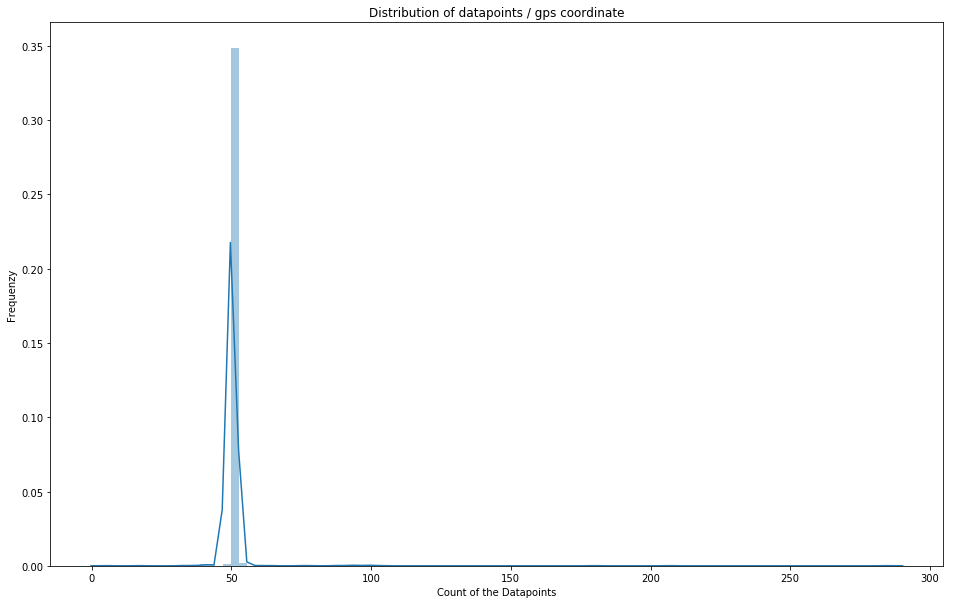

In [7]:
sns.distplot(agg_df["count"], 100)
plt.title("Distribution of datapoints / gps coordinate")
plt.xlabel("Count of the Datapoints")
plt.ylabel("Frequenzy")

The data point are equally distributed

### Prepare data

In [8]:
def butter_high(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_high_filter(data, cutoff, fs, order=5):
    b, a = butter_high(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [9]:
df.columns

Index(['time', 'measurementID', 'lat', 'lon', 'height', 'velocity',
       'direction', 'h_accuracy', 'v_accuracy', 'id_gps', 'x_lin_acc',
       'y_lin_acc', 'z_lin_acc', 'x_gyro', 'y_gyro', 'z_gyro', 'x_acc',
       'y_acc', 'z_acc', 'label'],
      dtype='object')

In [10]:
def filter_acc(df, cutoff=2, fs=50, order=2):

    signals = [ 'x_lin_acc', 'y_lin_acc', 'z_lin_acc','x_acc', 'y_acc', 'z_acc',]

    new_df = pd.DataFrame(columns=signals)

    for label in df.label.unique():

        label_df = df[df.label == label]

        list_signals = []

        for j in signals:

            filtered_signal = butter_high_filter(label_df[j], cutoff=cutoff, fs=fs, order=order)

            list_signals.append(filtered_signal)

        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df

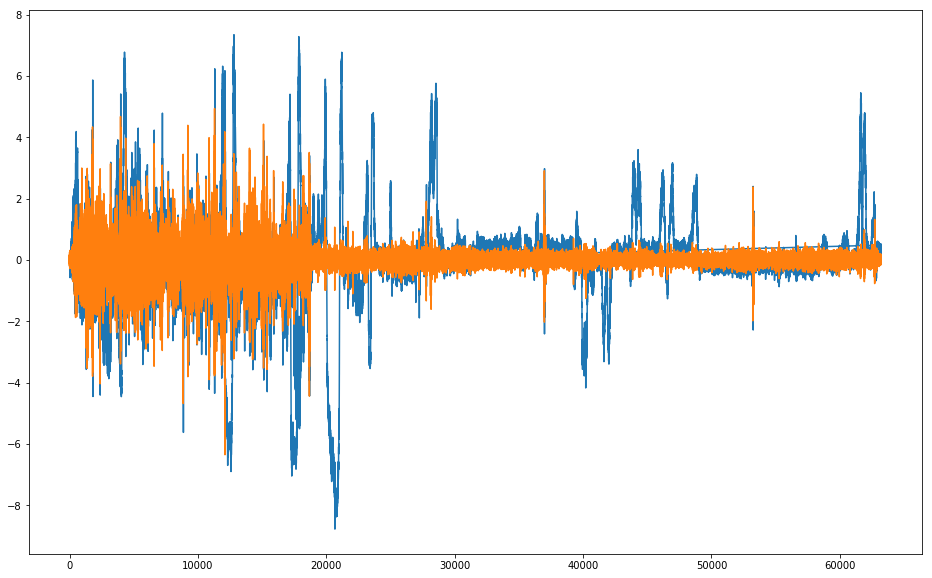

In [96]:
df["x_acc"].plot()
filter_acc(df)["x_acc"].plot()

In [11]:
def filter_gyro(df, cutoff=10, fs=50, order=2):

    signals = ['x_gyro', 'y_gyro', 'z_gyro']

    new_df = pd.DataFrame(columns=signals)

    for label in df.label.unique():

        label_df = df[df.label == label]

        list_signals = []

        for j in signals:

            filtered_signal = butter_high_filter(label_df[j], cutoff=cutoff, fs=fs, order=order)

            list_signals.append(filtered_signal)

        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df

In [103]:
df.drop(filter_acc(df).columns,axis=1)

,time,lat,lon,height,velocity,direction,h_accuracy,v_accuracy,id_gps,x_gyro,y_gyro,z_gyro,label
14,0.14,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.010804,0.001345,-0.033967,0
15,0.15,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,0.001346,0.008800,-0.035701,0
16,0.16,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.007075,0.005302,-0.027966,0
17,0.17,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.007945,0.006663,-0.028829,0
18,0.18,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.004748,-0.002140,-0.035702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12875,128.75,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.027666,-0.029211,-0.012400,2
12876,128.76,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.035673,-0.008810,-0.015961,2
12877,128.77,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.041637,0.014038,-0.008203,2
12878,128.78,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.061041,0.035687,0.000275,2


In [112]:
filtered_df = filter_acc(df)
filtered_df.shape

(94893, 6)

In [115]:
new_df = df.drop(filtered_df.columns, axis=1)

In [120]:
df = pd.concat([new_df.reset_index(),filtered_df.reset_index()], axis=1)

In [12]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', "z_lin_acc", 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["label", "id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})

    return agg_df

In [13]:
feature_df = create_aggregated(df).reset_index()

In [14]:
feature_df.head()

label id_gps x_lin_acc                                                    \
                     sum      mean       mad    median       min       max   
0     0      2 -1.649796 -0.032996  0.063512 -0.028106 -0.260537  0.236575   
1     0      3 -2.217652 -0.044353  0.056931 -0.040929 -0.199370  0.197633   
2     0      4  9.712292  0.194246  0.108982  0.199365 -0.113289  0.490266   
3     0      5  1.447531  0.028951  0.056508  0.033353 -0.213006  0.159516   
4     0      6 -6.488952 -0.129779  0.106860 -0.150999 -0.383144  0.197703   

                       ...    z_gyro                                          \
        std       var  ...       min       max       std       var       sem   
0  0.085715  0.007347  ...  0.007717  0.023898  0.003663  0.000013  0.000518   
1  0.074033  0.005481  ...  0.006597  0.025231  0.004161  0.000017  0.000588   
2  0.142251  0.020235  ... -0.024719  0.025446  0.013300  0.000177  0.001881   
3  0.073828  0.005451  ... -0.018960 -0.004329  0.002807  0.000008  0.000397   
4  0.133550  0.017835  ... -0.017997  0.012989  0.006980  0.000049  0.000987   

                                                         
       skew  quantile kurtosis_time   rms_100     crest  
0  0.440271  0.014481     -0.309927  0.015114  1.581151  
1  0.037274  0.016135     -0.038140  0.016571  1.522644  
2  1.897102 -0.019297      2.027520  0.018956  1.342376  
3  0.434150 -0.012554      0.877856  0.013120  1.445057  
4 -0.881184  0.001527      0.511352  0.006918  2.601624  

[5 rows x 128 columns]

## Shuffle Data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = feature_df.drop(["label"], axis=1)
y = feature_df["label"]

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [17]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  shuffle = True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    shuffle =  True)

In [19]:
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (611, 127)
X_val:  (375, 127)
X_test:  (262, 127)
y_train:  (611,)
y_val:  (375,)
y_test:  (262,)


Checking the number of the labels in the train, validation and test datasets.

In [20]:
print("Number of label for each label in the train dataset: {}".format(Counter(y_train).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_val).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_test).most_common()))

Number of label for each label in the train dataset: [(0, 272), (1, 190), (2, 149)]
Number of label for each label in the validation dataset: [(0, 172), (1, 114), (2, 89)]
Number of label for each label in the validation dataset: [(0, 117), (2, 80), (1, 65)]


##  Prepare for ML

In [21]:
feature_df.columns

MultiIndex([(    'label',              ''),
            (   'id_gps',              ''),
            ('x_lin_acc',           'sum'),
            ('x_lin_acc',          'mean'),
            ('x_lin_acc',           'mad'),
            ('x_lin_acc',        'median'),
            ('x_lin_acc',           'min'),
            ('x_lin_acc',           'max'),
            ('x_lin_acc',           'std'),
            ('x_lin_acc',           'var'),
            ...
            (   'z_gyro',           'min'),
            (   'z_gyro',           'max'),
            (   'z_gyro',           'std'),
            (   'z_gyro',           'var'),
            (   'z_gyro',           'sem'),
            (   'z_gyro',          'skew'),
            (   'z_gyro',      'quantile'),
            (   'z_gyro', 'kurtosis_time'),
            (   'z_gyro',       'rms_100'),
            (   'z_gyro',         'crest')],
           length=128)

In [22]:
feature_df.drop(["label"], axis=1).columns

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



MultiIndex([(   'id_gps',              ''),
            ('x_lin_acc',           'sum'),
            ('x_lin_acc',          'mean'),
            ('x_lin_acc',           'mad'),
            ('x_lin_acc',        'median'),
            ('x_lin_acc',           'min'),
            ('x_lin_acc',           'max'),
            ('x_lin_acc',           'std'),
            ('x_lin_acc',           'var'),
            ('x_lin_acc',           'sem'),
            ...
            (   'z_gyro',           'min'),
            (   'z_gyro',           'max'),
            (   'z_gyro',           'std'),
            (   'z_gyro',           'var'),
            (   'z_gyro',           'sem'),
            (   'z_gyro',          'skew'),
            (   'z_gyro',      'quantile'),
            (   'z_gyro', 'kurtosis_time'),
            (   'z_gyro',       'rms_100'),
            (   'z_gyro',         'crest')],
           length=127)

In [23]:
if not os.path.exists("../data/train_test_val"):
        os.makedirs("../data/train_test_val")

cols = feature_df.drop(["label"], axis=1).columns
        
pd.DataFrame(X_train, columns=cols).to_csv( "../data/train_test_val/X_train.csv")
pd.DataFrame(X_val, columns=cols).to_csv("../data/train_test_val/X_val.csv")
pd.DataFrame(X_test, columns=cols).to_csv("../data/train_test_val/X_test.csv")
        
pd.DataFrame(y_train).to_csv( "../data/train_test_val/y_train.csv")
pd.DataFrame(y_val).to_csv("../data/train_test_val/y_val.csv")
pd.DataFrame(y_test).to_csv("../data/train_test_val/y_test.csv")

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [24]:
pd.read_csv("../data/train_test_val/X_test.csv", header=[0,1], index_col=0)

id_gps  x_lin_acc                                          \
     Unnamed: 1_level_1        sum      mean       mad    median       min   
216                 219   0.777329  0.015547  0.174615  0.047523 -0.501717   
1055                127   8.595989  0.085960  0.343803  0.126789 -1.613355   
753                 193   7.855975  0.078560  0.326096 -0.022787 -0.525889   
577                  17 -20.204003 -0.132921  0.454108 -0.150396 -3.040550   
521                 588  -2.061350 -0.041227  0.098289 -0.038923 -0.283358   
...                 ...        ...       ...       ...       ...       ...   
959                  31 -89.493787 -0.596625  0.828861 -0.340617 -3.234558   
1021                 93   5.046097  0.033641  0.678191  0.022685 -2.650628   
647                  87  21.026178  0.140175  0.349241  0.173809 -4.263890   
1015                 87  -1.731230 -0.011542  0.483618 -0.047194 -2.958850   
1229                322  -0.729132 -0.014583  0.408548 -0.002272 -1.390827   

                                              ...    z_gyro            \
           max       std       var       sem  ...       min       max   
216   0.635126  0.221625  0.049118  0.031342  ...  0.019396  0.060440   
1055  1.788411  0.527513  0.278270  0.052751  ... -0.028156  0.052252   
753   1.083576  0.405098  0.164105  0.040510  ... -0.211356  0.029557   
577   4.833078  0.800214  0.640342  0.064906  ... -0.039129  0.081318   
521   0.376723  0.128576  0.016532  0.018183  ... -0.028348 -0.009550   
...        ...       ...       ...       ...  ...       ...       ...   
959   1.225475  1.008263  1.016595  0.082324  ... -0.071360  0.329160   
1021  2.133578  0.865925  0.749827  0.070703  ... -0.187510  0.049196   
647   2.131999  0.608563  0.370348  0.049689  ... -0.048568  0.081753   
1015  2.718648  0.707373  0.500376  0.057757  ... -0.063926  0.057734   
1229  1.068678  0.534948  0.286169  0.075653  ... -0.025820  0.034853   

                                                                      \
           std       var       sem      skew  quantile kurtosis_time   
216   0.009262  0.000086  0.001310 -0.558043  0.045892     -0.163771   
1055  0.015692  0.000246  0.001569  0.957135 -0.001987      1.822394   
753   0.098865  0.009774  0.009887 -0.058235 -0.068532     -1.912393   
577   0.022815  0.000521  0.001851  0.384400  0.010270     -0.403795   
521   0.003760  0.000014  0.000532 -0.177221 -0.017423      0.275626   
...        ...       ...       ...       ...       ...           ...   
959   0.119716  0.014332  0.009775  0.895077  0.021727     -0.607232   
1021  0.063255  0.004001  0.005165 -0.778060 -0.012326     -0.770064   
647   0.024345  0.000593  0.001988  0.163534  0.007806     -0.850862   
1015  0.019705  0.000388  0.001609 -0.175212  0.009381      0.825721   
1229  0.013516  0.000183  0.001912  0.560981 -0.003712      0.002520   

                          
       rms_100     crest  
216   0.045715  1.322102  
1055  0.015830  3.300859  
753   0.126119  1.675854  
577   0.026730  3.042231  
521   0.017465  1.623165  
...        ...       ...  
959   0.141739  2.322294  
1021  0.074136  2.529279  
647   0.026774  3.053484  
1015  0.021504  2.972784  
1229  0.013625  2.558107  

[262 rows x 127 columns]